## Natural Language Processing - SMS Spam Detection

**Let's train a model to predict spam messages!**

Description of the data:
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.


Dataset used: SMS Spam Collection Dataset, UCI

### Importing Initial Libraries

In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
sns.set_style('darkgrid')

## Data Cleaning and Preparation

In [213]:
#reading the data
df = pd.read_csv('../input/sms-spam-collection-dataset/spam.csv',encoding='latin1')

#printing data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


**The 2nd, 3rd, and 4th columns are having too many null values.**

**Let's explore these columns in detail.**


In [214]:
#Exploring some parts of the data where messages are found in Unnamed:3 and Unnamed:4 columns.

df[df.columns.drop(['v1','v2'])].dropna(how='all').head(10)

,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,"this wont even start........ Datz confidence..""",NaN,NaN
899,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,GN,GE,"GNT:-)"""
1127,".;-):-D""",NaN,NaN
1266,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,"bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


**The columns other than v1 and v2 also have messages (shown above).**

In [215]:
df.loc[df['v1'] == 'spam',df.columns.drop(['v1','v2'])].dropna()

,Unnamed: 2,Unnamed: 3,Unnamed: 4


**None of the columns Unnamed: 2, Unnamed: 3 and Unnamed: 4 have any *Spam* messages.**

**Hence we are labelling the messages in these columns as *ham***

**Let's try to rearrage these columns to a two column dataframe, where one is for labels and the other is for  messages.**

In [216]:
#Assigning label ham to messages in Unnamed: 2, Unnamed: 3, Unnamed: 4 and concatenating them with v2
temp1 = df[['v2','v1']]

temp2 = df['Unnamed: 2'].to_frame()
temp2.loc[:,'v1'] = 'ham'
temp2 = temp2.rename(columns={'Unnamed: 2':'v2'})

temp3 = df['Unnamed: 3'].to_frame()
temp3.loc[:,'v1'] = 'ham'
temp3 = temp3.rename(columns={'Unnamed: 3':'v2'})

temp4 = df['Unnamed: 4'].to_frame()
temp4.loc[:,'v1'] = 'ham'
temp4 = temp4.rename(columns={'Unnamed: 4':'v2'})

df = pd.concat([temp1,temp2,temp3,temp4],axis=0).dropna().reindex(columns=['v1','v2'])

In [217]:
#Let's print the last 10 messages in our dataframe
df.tail(10)

,v1,v2
3525,ham,TX 4 FONIN HON
4668,ham,"\""OH No! COMPETITION\"". Who knew"
5048,ham,GE
5081,ham,"IåÕL CALL U\"""""
281,ham,"just Keep-in-touch\"" gdeve.."""
1038,ham,"GNT:-)"""
2255,ham,"Never comfort me with a lie\"" gud ni8 and swe..."
3525,ham,"CALL 2MWEN IM BK FRMCLOUD 9! J X\"""""
4668,ham,"one day these two will become FREINDS FOREVER!"""
5048,ham,"GNT:-)"""


**Let's change the column labels of the dataframe for readability.**

In [218]:
#rename the columns for readability
df.columns = ['label','message']

Let's have a look at the messages labelled as **spam**.

In [219]:
df[df['label'] == 'spam'].head(10)

,label,message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
12,spam,URGENT! You have won a 1 week FREE membership ...
15,spam,"XXXMobileMovieClub: To use your credit, click ..."
19,spam,England v Macedonia - dont miss the goals/team...
34,spam,Thanks for your subscription to Ringtone UK yo...
42,spam,07732584351 - Rodger Burns - MSG = We tried to...


**Spam** messages seem to be well structured and lengthy.

Let's have a look at the countplot of labels.

percentage of labels:          message
label           
ham    86.755319
spam   13.244681


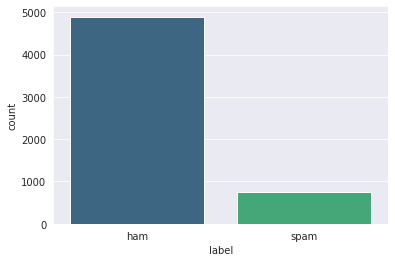

In [220]:
#plotting frequency vs label name
_=sns.countplot(data=df,x='label',palette='viridis')
print("percentage of labels:",f"{100*df.groupby('label').count()/len(df)}")

**ham** messages are high in number compared to **spam** messages. The dataset is slightly imbalanced or skewed. We have to take this imbalance into account while training the model.

Let's have a look at distribution of message sizes.

In [221]:
#prepare a length column
df['len'] = df['message'].apply(len)

Usually spam messages are larger than personal messages. Let's comapare the distribution of the lengths of **spam** and **ham** messages.

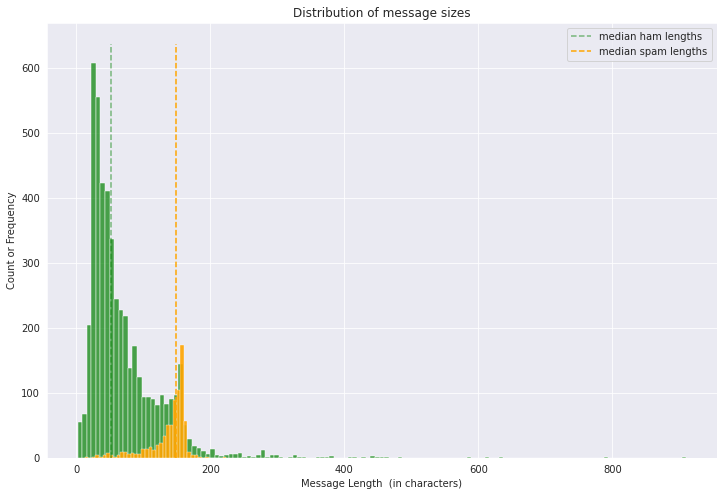

In [222]:
fig,ax=plt.subplots(figsize=(12,8))
check = 'ham'
sns.histplot(df[df['label']==check],x='len',color='green',ax=ax,alpha=0.7)
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x=df.loc[df['label']==check,'len'].median(),ymin=ymin,ymax=ymax,color='green',alpha=0.5,linestyles='dashed')
check = 'spam'
sns.histplot(df[df['label']==check],x='len',color='orange',ax=ax,alpha=0.9)
plt.vlines(x=df.loc[df['label']==check,'len'].median(),ymin=ymin,ymax=ymax,color='orange',linestyles='dashed')
plt.legend(['median ham lengths','median spam lengths'])
_=plt.title('Distribution of message sizes')
_=plt.ylabel('Count or Frequency')
_=plt.xlabel('Message Length  (in characters)')


**The median of both the frequency distributions indicate that personal messages are mostly short and spam messages are lengthy! Hence we can use the length of messages as a feature while training the model.**

## Feature Engineering

In [223]:
#importing functions that helps in feature engineering
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

In [224]:
#Collecting words and punctuations to be removed in a list
remove_list = set(list(string.punctuation) + stopwords.words('english'))
#defining a function that can tokenize the messages, remove unwanted words and punctuations
porterstemmer = PorterStemmer()
def message_cleaner(message):
    cleaned_message = []
    for word in word_tokenize(message.lower()):
        word = re.sub('[^a-zA-Z]','',word)
        if(word == ''):
            continue
        if(word not in remove_list):
            cleaned_message.append(porterstemmer.stem(word))
    return cleaned_message

Let's test the message cleaner function using a dummy messsage.

In [225]:
message_cleaner('Hey, Are you attending that guitar competition?')

['hey', 'attend', 'guitar', 'competit']

Cool. The function seems to do it's job. Now let's calculate tf-idf features from the messages.

**The TfidfVectorizer function will run the analyzer (message_cleaner) through each of the messages and create a sparse matrix of words and it's frequency. It then calculates the tf-idf features from this matrix. The length for each message is also calculated and appended to the matrix as a feature.**

**We must split the dataset into train and test data for further processing.**

In [226]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

**Let's map labels *spam* to 1 and *ham* to 0**

In [227]:
df['label'] = df['label'].map(lambda x: 0 if(x=='ham') else 1)

In [228]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(df['message'],df['label'],test_size=0.25)

In [229]:
from sklearn.pipeline import FeatureUnion 
#FeatureUnion is used to concat feaatures obtained using different transform functions
from sklearn.preprocessing import FunctionTransformer
#FunctionTransformer can create a transform function from any arbitrary or user defined function
from scipy.sparse import csr_matrix

**Writing a function that can calculate and return the length of messages in sparse matrix format**

In [230]:
def get_length(df):
    df = df.apply(len)
    return csr_matrix(df.to_numpy().reshape(-1,1))

**Let's unite the TfidfVectorizer and get_length features to a single matrix using a FeatureUnion pipeline. The features matrix can then be created using the fit and transform method on this FeatureUnion object.**

In [231]:
feature_pipe = FeatureUnion([
    ('tfidf',TfidfVectorizer(analyzer=message_cleaner)),
    ('length',FunctionTransformer(get_length))])
tfidf_mat = feature_pipe.fit_transform(X_train)

**Let's print the shape of the feature matrix**

In [232]:
print('Shape of the matrix:', tfidf_mat.shape) # This is a very sparse matrix

Shape of the matrix: (4230, 5839)


**Let's check out the tf-idf features of words in the first message (message_num=0)**

In [233]:
message_num=0 #give the index value of message in DataFrame df

#get the indices of the token words in any message and its length
ind = tfidf_mat[message_num].nonzero()[1]
#print the corresponding word and its tf-idf weights, and the length of the whole message
for index in ind:
    if(index == (tfidf_mat.shape[1]-1)):
        print('\nmessage length:',tfidf_mat[message_num,index])
    else:
        print('Word:',feature_pipe.transformer_list[0][1].get_feature_names()[index],'  tf-idf:',tfidf_mat[message_num,index])

Word: aight   tf-idf: 0.32675550205928283
Word: closer   tf-idf: 0.4244190212666595
Word: jay   tf-idf: 0.3576556916923835
Word: latest   tf-idf: 0.31359962089409427
Word: probabl   tf-idf: 0.33604729383559856
Word: trip   tf-idf: 0.3413810282263896
Word: two   tf-idf: 0.3188457745479179
Word: tyler   tf-idf: 0.3945954918165719

message length: 121.0


## Training and tuning the model

Let's use the Multinomial naive bayes classifier to train the model and GridSearchCV to tune it

In [234]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

**Since the labels are imbalanced, we choose recall as the scoring method. Tuning the model using recall score will improve predictability of the spam messages.**

In [235]:
#define grid search
params =  {'alpha':[0.001,0.01,0.1,0.25,0.3,0.35,0.5,0.6,0.7,0.8,0.9,1,2,5]}
grid = GridSearchCV(MultinomialNB(),param_grid=params,cv=6,scoring='recall')
grid.fit(tfidf_mat,y_train)

GridSearchCV(cv=6, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.25, 0.3, 0.35, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1, 2, 5]},
             scoring='recall')

In [236]:
#print accuracy score
print(f'Accuracy score is: {grid.score(feature_pipe.transform(X_test),y_test):.2f}')
#Print the best parameter
print('Best parameter:',grid.best_params_)

Accuracy score is: 0.95
Best parameter: {'alpha': 0.01}


**Let's print and plot the result scores**

In [237]:
from sklearn.metrics import classification_report,confusion_matrix

In [238]:
#transform test data before predicting
transformed_X_test = feature_pipe.transform(X_test)

#classify test messages
predictions = grid.predict(transformed_X_test)
#print classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1246
           1       0.95      0.95      0.95       164

    accuracy                           0.99      1410
   macro avg       0.97      0.97      0.97      1410
weighted avg       0.99      0.99      0.99      1410



**We have a good recall and f1-score for both labels!**

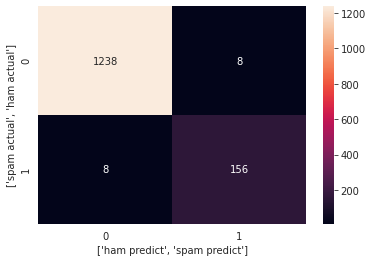

In [239]:
#create a confusion matrix
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='d')
plt.xlabel(['ham predict','spam predict'])
_=plt.ylabel(['spam actual','ham actual'])

## Thank You